## 1. Imports and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from decimal import Decimal
# PyTorch
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch_geometric.data import Data, Batch
import torch.optim as optim
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn import global_mean_pool
import torch_geometric
from torch.nn import Linear
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv, TransformerConv


#Sklearn
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Networkx
import networkx as nx



In [40]:
def calculate_node_features(graph):
    # Calcular las características de los nodos
    
    # Calcular el coeficiente de clustering para cada nodo
    clustering_coeffs = nx.clustering(graph)
    #Calcular el grado del nodo
    degree = nx.degree(graph)
    # Calcular Centralidad de intermediación
#    betweenness_centrality = nx.betweenness_centrality(graph)
#     # Calcular Centralidad de cercanía
#     closeness_centrality = nx.closeness_centrality(graph)
#     # Calular Centralidad de autovector
#     eigenvector_centrality = nx.eigenvector_centrality(graph)
#     #Calcular el PageRank para cada nodo
    pagerank = nx.pagerank(graph)

    # Obtener los nodos y sus características
    nodes = list(graph.nodes())
    x = torch.tensor([[clustering_coeffs[node], degree[node]#,#, betweenness_centrality[node],
                       #closeness_centrality[node], eigenvector_centrality[node],
                       ,pagerank[node]
                      ] for node in nodes], dtype=torch.float)

    return x

In [13]:
def load_gpickle_files(path):
    X_path = os.path.join(path, "X")  # Ruta de la carpeta con los grafos
    y_path = os.path.join(path, "y")  # Ruta de la carpeta con las etiquetas

    file_list = os.listdir(X_path)  # Obtén la lista de archivos gpickle
    dataset = []

    for file in file_list:
        file_path = os.path.join(X_path, file)  # Genera la ruta del archivo
        graph = nx.read_gpickle(file_path)  # Lee el archivo gpickle con NetworkX

        # Calcular las características de los nodos
        x = calculate_node_features(graph)
        # Obtiene la matriz dispersa de adyacencia
        adj_matrix = nx.convert_matrix.to_scipy_sparse_matrix(graph)

        # Convierte la matriz dispersa en un tensor de PyTorch
        edge_index = torch.from_numpy(np.vstack(adj_matrix.nonzero()))
#         edge_index = torch.tensor(list(graph.edges()), dtype=torch.long).t().contiguous()  # Índices de las aristas
#         adj_matrix = nx.adjacency_matrix(graph)
#         adj_matrix = adj_matrix.toarray()

        file_number = os.path.splitext(file)[0]
        with open(os.path.join(y_path, f"{file_number}.txt")) as f:
            target = f.read()
            y = torch.tensor(np.float_(target), dtype=torch.float)

        data = Data(x=x, edge_index=edge_index, y=y)  # Crea un objeto Data
        dataset.append(data)

    return dataset

def custom_collate(batch):
    # Extraer los elementos del lote y crear listas separadas para cada atributo
    x_list = []
    edge_index_list = []
    y_list = []

    for data in batch:
        x_list.append(data.x)
        edge_index_list.append(data.edge_index)
        y_list.append(data.y)

    # Convertir las listas en arreglos de numpy
    x_batch = np.stack(x_list)
    edge_index_batch = np.stack(edge_index_list)
    y_batch = np.stack(y_list)

    return Data(x=x_batch, edge_index=edge_index_batch, y=y_batch)

def plot_learning_curves(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 6))

    # Plot losses
    plt.plot(epochs, train_losses, label='Train')
    plt.plot(epochs, val_losses, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Curva de Aprendizaje')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def train(model, num_epochs, dataset, data_test):
    
    #model3=GNN(input_size=3, hidden_channels=3)
    learning_rate = 0.001
    # Definir la función de pérdida y el optimizador
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Listas para almacenar las pérdidas en cada época
    train_losses = []
    val_losses = []

    #num_epochs = 12
    model.train()  # Cambiar al modo de entrenamiento

    for epoch in range(num_epochs):
        running_loss = 0.0

        for data in dataset:
            x = data.x  # Características de los nodos
            edge_index = data.edge_index
            y = data.y#.view(-1)#.to(device)  # Etiquetas o clases

            optimizer.zero_grad()
            logits = model(x=x, edge_index=edge_index)
            loss = loss_fn(logits, y)
            loss.backward()  # Realizar el paso de atrás (backward)
            optimizer.step()  # Actualizar los pesos del modelo

            running_loss += loss.item()

        # Calcular la pérdida promedio en cada época
        epoch_loss = running_loss / len(dataset)
        train_losses.append(epoch_loss)

        # Realizar la validación del modelo en cada época
        model.eval()  # Cambiar al modo de evaluación

        with torch.no_grad():
            running_val_loss = 0.0

            for data in data_test:
                x_val = data.x
                edge_index_val = data.edge_index
                y_val = data.y#.view(-1)#.to(device)

                val_logits = model(x=x_val, edge_index=edge_index_val)
                val_loss = loss_fn(val_logits, y_val)

                running_val_loss += val_loss.item()

            # Calcular la pérdida promedio en la validación
            val_epoch_loss = running_val_loss / len(data_test)
            val_losses.append(val_epoch_loss)

        # Imprimir información del progreso del entrenamiento
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}')

    # Crear las curvas de aprendizaje
    plot_learning_curves(train_losses, val_losses)
    
def testing(model, dataset):
    model.eval()  # Set the model in evaluation mode
    total_samples = 0
    total_loss = 0
    predictions_list = []
    labels_list = []

    learning_rate = 0.001
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    with torch.no_grad():
        for data in dataset:
            x = data.x  # Características de los nodo
            edge_index = data.edge_index
            y = data.y.unsqueeze(0)#.view(-1)#.to(device)  # Etiquetas o clases


            predictions = model(x=x, edge_index=edge_index)  # Forward pass

            loss = loss_fn(predictions, y)
            total_loss += loss.item()

            predictions_list.append(predictions.detach().cpu().numpy())
            labels_list.append(y.detach().cpu().numpy())

        # Calculate accuracy
        predictions_array = np.concatenate(predictions_list, axis=0)
        labels_array = np.concatenate(labels_list, axis=0)
        # Calculate MSE
        mse = mean_squared_error(labels_array, predictions_array)

        # Calculate MAE
        mae = mean_absolute_error(labels_array, predictions_array)

        # Calculate RMSE
        rmse = mean_squared_error(labels_array, predictions_array, squared=False)

        # Calculate R-squared
        r2 = r2_score(labels_array, predictions_array)

        print("MSE:", mse)
        print("MAE:", mae)
        print("RMSE:", rmse)
        print("R-squared:", r2)

        #print("Accuracy: {:.4f}".format(accuracy))
        # print("Mean Squared Error (MSE): {:.4f}".format(mse))
        # print("R-squared (R²): {:.4f}".format(r2))
        fig, ax = plt.subplots()
        ax.scatter(labels_array, predictions_array)
        ax.axline((0, 0), slope=1, color='red')
        # Add labels and title
        plt.xlabel("Labels")
        plt.ylabel("Predictions")
        plt.title("Predictions vs. Labels")
        

        # Display the plot
        plt.show()

## 2. Load data

#### Training data

In [41]:
training = load_gpickle_files(r"C:\Users\l.sanchezparra\Documents\Personal\TFG\Python code\Dataset\500\Train")  # Carga los datos con la función load_gpickle_files

#### Validation data

In [42]:
validation = load_gpickle_files(r"C:\Users\l.sanchezparra\Documents\Personal\TFG\Python code\Dataset\500\Validation")  # Carga los datos con la función load_gpickle_files

#### Test data

In [43]:
test = load_gpickle_files(r"C:\Users\l.sanchezparra\Documents\Personal\TFG\Python code\Dataset\500\Test")  # Carga los datos con la función load_gpickle_files

## 3. GAT Models

#### GATConv: 1 layer

In [10]:
class OneGATLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_channels):
        super(OneGATLayer, self).__init__()
        torch.manual_seed(12345)
        
        self.conv1 = GATConv(input_size, hidden_channels)
        
        
        self.lin = Linear(hidden_channels, 1)
    
    def forward(self, x, edge_index, batch = None,  edge_col = None):
        
        # Node embedding 
        x = self.conv1(x, edge_index, edge_col)
               
        # Readout layer
        batch = torch.zeros(x.shape[0],dtype=int) if batch is None else batch
        x = global_mean_pool(x, batch)
        
        # Final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
    
        return x

C:\Users\l.sanchezparra\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/20], Train Loss: 0.3261, Val Loss: 0.0775
Epoch [2/20], Train Loss: 0.0727, Val Loss: 0.0578
Epoch [3/20], Train Loss: 0.0290, Val Loss: 0.0166
Epoch [4/20], Train Loss: 0.0136, Val Loss: 0.0119
Epoch [5/20], Train Loss: 0.0110, Val Loss: 0.0095
Epoch [6/20], Train Loss: 0.0080, Val Loss: 0.0085
Epoch [7/20], Train Loss: 0.0060, Val Loss: 0.0088
Epoch [8/20], Train Loss: 0.0052, Val Loss: 0.0088
Epoch [9/20], Train Loss: 0.0047, Val Loss: 0.0088
Epoch [10/20], Train Loss: 0.0045, Val Loss: 0.0089
Epoch [11/20], Train Loss: 0.0043, Val Loss: 0.0088
Epoch [12/20], Train Loss: 0.0042, Val Loss: 0.0085
Epoch [13/20], Train Loss: 0.0041, Val Loss: 0.0077
Epoch [14/20], Train Loss: 0.0040, Val Loss: 0.0067
Epoch [15/20], Train Loss: 0.0039, Val Loss: 0.0056
Epoch [16/20], Train Loss: 0.0038, Val Loss: 0.0047
Epoch [17/20], Train Loss: 0.0037, Val Loss: 0.0041
Epoch [18/20], Train Loss: 0.0036, Val Loss: 0.0037
Epoch [19/20], Train Loss: 0.0035, Val Loss: 0.0034
Epoch [20/20], Train 

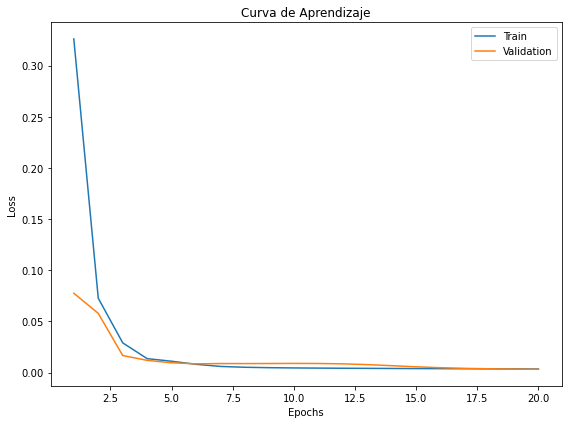

C:\Users\l.sanchezparra\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE: 0.0030735459
MAE: 0.044564348
RMSE: 0.05543957
R-squared: 0.9631333833369049


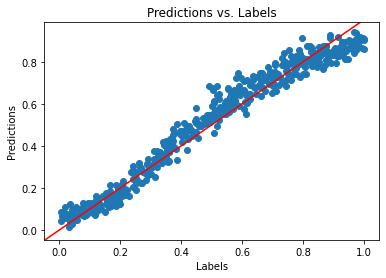

In [44]:
model1=OneGATLayer(input_size=3, hidden_channels=3)
train(model1, 20, training, validation)
testing(model1, test)

#### GATConv: 2 layers

In [33]:
class TwoGATLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_channels):
        super(TwoGATLayer, self).__init__()
        torch.manual_seed(12345)
        
        self.conv1 = GATConv(input_size, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        
        self.lin = Linear(hidden_channels, 1)
    
    def forward(self, x, edge_index, batch = None,  edge_col = None):
        
        # Node embedding 
        x = self.conv1(x, edge_index, edge_col)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_col)
        
        # Readout layer
        batch = torch.zeros(x.shape[0],dtype=int) if batch is None else batch
        x = global_mean_pool(x, batch)
        
        # Final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
    
        return x

C:\Users\l.sanchezparra\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/20], Train Loss: 0.0902, Val Loss: 0.0688
Epoch [2/20], Train Loss: 0.0348, Val Loss: 0.0149
Epoch [3/20], Train Loss: 0.0130, Val Loss: 0.0120
Epoch [4/20], Train Loss: 0.0098, Val Loss: 0.0104
Epoch [5/20], Train Loss: 0.0081, Val Loss: 0.0080
Epoch [6/20], Train Loss: 0.0069, Val Loss: 0.0103
Epoch [7/20], Train Loss: 0.0060, Val Loss: 0.0095
Epoch [8/20], Train Loss: 0.0054, Val Loss: 0.0089
Epoch [9/20], Train Loss: 0.0049, Val Loss: 0.0082
Epoch [10/20], Train Loss: 0.0045, Val Loss: 0.0075
Epoch [11/20], Train Loss: 0.0041, Val Loss: 0.0069
Epoch [12/20], Train Loss: 0.0038, Val Loss: 0.0063
Epoch [13/20], Train Loss: 0.0036, Val Loss: 0.0057
Epoch [14/20], Train Loss: 0.0035, Val Loss: 0.0053
Epoch [15/20], Train Loss: 0.0034, Val Loss: 0.0049
Epoch [16/20], Train Loss: 0.0033, Val Loss: 0.0046
Epoch [17/20], Train Loss: 0.0033, Val Loss: 0.0045
Epoch [18/20], Train Loss: 0.0033, Val Loss: 0.0043
Epoch [19/20], Train Loss: 0.0033, Val Loss: 0.0042
Epoch [20/20], Train 

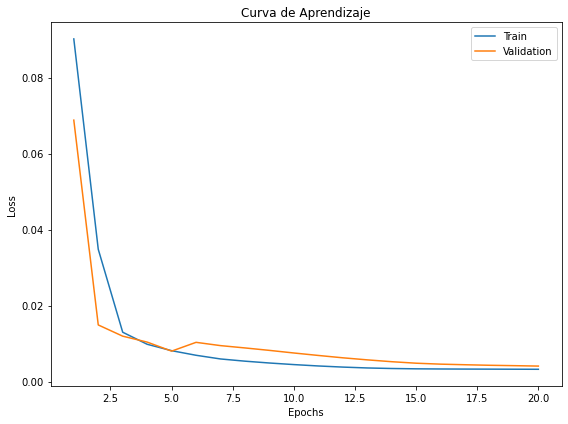

C:\Users\l.sanchezparra\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE: 0.003779672
MAE: 0.051236715
RMSE: 0.06147904
R-squared: 0.9546635319318297


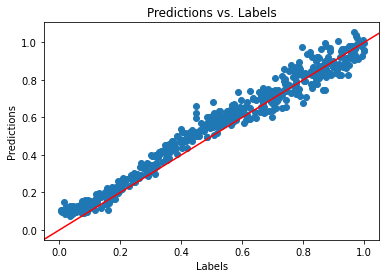

In [45]:
model2=TwoGATLayer(input_size=3, hidden_channels=3)
train(model2, 20, training, validation)
testing(model2, test)

#### GATConv: 3 layers

In [35]:
class ThreeGATLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_channels):
        super(ThreeGATLayer, self).__init__()
        torch.manual_seed(12345)
        
        self.conv1 = GATConv(input_size, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)
        
        self.lin = Linear(hidden_channels, 1)
    
    def forward(self, x, edge_index, batch = None,  edge_col = None):
        
        # Node embedding 
        x = self.conv1(x, edge_index, edge_col)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_col)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_col)
               
        # Readout layer
        batch = torch.zeros(x.shape[0],dtype=int) if batch is None else batch
        x = global_mean_pool(x, batch)
        
        # Final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
    
        return x

C:\Users\l.sanchezparra\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/20], Train Loss: 0.0660, Val Loss: 0.0287
Epoch [2/20], Train Loss: 0.0103, Val Loss: 0.0051
Epoch [3/20], Train Loss: 0.0065, Val Loss: 0.0044
Epoch [4/20], Train Loss: 0.0056, Val Loss: 0.0049
Epoch [5/20], Train Loss: 0.0052, Val Loss: 0.0044
Epoch [6/20], Train Loss: 0.0048, Val Loss: 0.0041
Epoch [7/20], Train Loss: 0.0045, Val Loss: 0.0039
Epoch [8/20], Train Loss: 0.0042, Val Loss: 0.0040
Epoch [9/20], Train Loss: 0.0040, Val Loss: 0.0035
Epoch [10/20], Train Loss: 0.0038, Val Loss: 0.0034
Epoch [11/20], Train Loss: 0.0035, Val Loss: 0.0031
Epoch [12/20], Train Loss: 0.0033, Val Loss: 0.0023
Epoch [13/20], Train Loss: 0.0030, Val Loss: 0.0023
Epoch [14/20], Train Loss: 0.0030, Val Loss: 0.0023
Epoch [15/20], Train Loss: 0.0029, Val Loss: 0.0022
Epoch [16/20], Train Loss: 0.0028, Val Loss: 0.0022
Epoch [17/20], Train Loss: 0.0028, Val Loss: 0.0022
Epoch [18/20], Train Loss: 0.0027, Val Loss: 0.0022
Epoch [19/20], Train Loss: 0.0027, Val Loss: 0.0021
Epoch [20/20], Train 

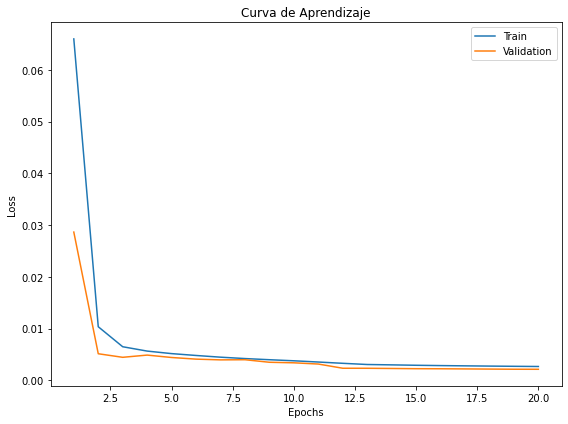

C:\Users\l.sanchezparra\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE: 0.0019969067
MAE: 0.03255544
RMSE: 0.04468676
R-squared: 0.9760474743492564


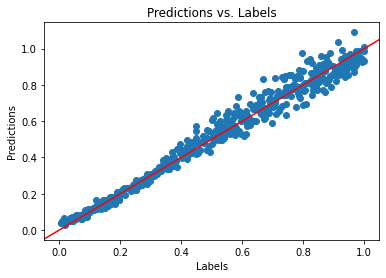

In [46]:
model3=ThreeGATLayer(input_size=3, hidden_channels=3)
train(model3, 20, training, validation)
testing(model3, test)

C:\Users\l.sanchezparra\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE: 0.0159196
MAE: 0.09795787
RMSE: 0.1261729
R-squared: 0.8090473385444432


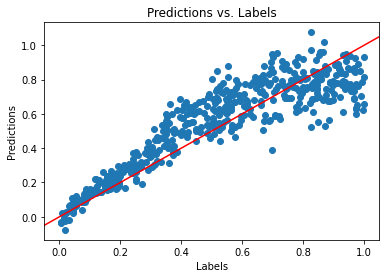

In [21]:
testing(model3, test)

#### GATConv: 4 layers

In [22]:
class FourGATLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_channels):
        super(FourGATLayer, self).__init__()
        torch.manual_seed(12345)
        
        self.conv1 = GATConv(input_size, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)
        self.conv4 = GATConv(hidden_channels, hidden_channels)
        
        
        self.lin = Linear(hidden_channels, 1)
    
    def forward(self, x, edge_index, batch = None,  edge_col = None):
        
        # Node embedding 
        x = self.conv1(x, edge_index, edge_col)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_col)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_col)
        x = x.relu()
        x = self.conv4(x, edge_index, edge_col)
               
        # Readout layer
        batch = torch.zeros(x.shape[0],dtype=int) if batch is None else batch
        x = global_mean_pool(x, batch)
        
        # Final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
    
        return x

C:\Users\l.sanchezparra\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10], Train Loss: 0.0645, Val Loss: 0.0185
Epoch [2/10], Train Loss: 0.0063, Val Loss: 0.0071
Epoch [3/10], Train Loss: 0.0042, Val Loss: 0.0073
Epoch [4/10], Train Loss: 0.0037, Val Loss: 0.0076
Epoch [5/10], Train Loss: 0.0035, Val Loss: 0.0076
Epoch [6/10], Train Loss: 0.0034, Val Loss: 0.0073
Epoch [7/10], Train Loss: 0.0032, Val Loss: 0.0063
Epoch [8/10], Train Loss: 0.0030, Val Loss: 0.0063
Epoch [9/10], Train Loss: 0.0029, Val Loss: 0.0061
Epoch [10/10], Train Loss: 0.0028, Val Loss: 0.0059


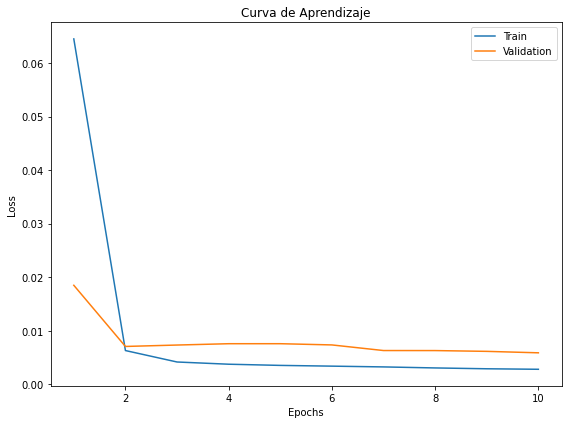

C:\Users\l.sanchezparra\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE: 0.0055870926
MAE: 0.06410846
RMSE: 0.074746855
R-squared: 0.9329838596886796


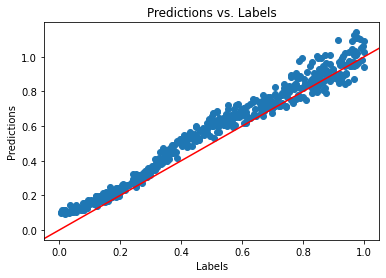

In [47]:
model4=FourGATLayer(input_size=3, hidden_channels=3)
train(model4, 20, training, validation)
testing(model4, test)